In [24]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [25]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [26]:
print('Num of Review(Train):', len(train_data))
print('Num of Review(Test):', len(test_data))
print("Column: ", train_data.columns)
print(train_data['document'].nunique(), train_data['label'].nunique())

Num of Review(Train): 150000
Num of Review(Test): 50000
Column:  Index(['id', 'document', 'label'], dtype='object')
146182 2


In [27]:
def dropNan(df):
    df.drop_duplicates(subset=['document'], inplace=True)
    df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
    df['document'] = df['document'].str.replace('^ +', "", regex=True)
    df['document'].replace('', np.nan, inplace=True)
    df.dropna(how = 'any', inplace=True)

In [5]:
dropNan(train_data)
dropNan(test_data)

In [6]:
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [7]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [
        word for word in tokenized_sentence 
        if not word in stopwords]
    X_train.append(stopwords_removed_sentence)
    

100%|████████████████████████████████| 145393/145393 [00:05<00:00, 26682.03it/s]


In [8]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [
        word for word in tokenized_sentence 
        if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████████████████████████████| 48852/48852 [00:01<00:00, 27493.13it/s]


In [9]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [28]:
import platform
if platform.system() == 'Windows':
    is_mac = False
else:
    is_mac = True
print(is_mac)

False


In [29]:
if is_mac:
    with open('x_data.pkl', 'wb') as f:
        pickle.dump((X_train, X_valid, X_test), f)
    with open('y_data.pkl', 'wb') as f:
        pickle.dump((y_train, y_valid, y_test), f)
else:
    with open('x_data.pkl', 'rb') as f:
        (X_train, X_valid, X_test) = pickle.load(f)
    with open('y_data.pkl', 'rb') as f:
        (y_train, y_valid, y_test) = pickle.load(f)

In [30]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


In [31]:
word_list = []
for sent in X_train:
    for word in sent:
        word_list.append(word)
word_counts = Counter(word_list)
print('total Number of Words: ', len(word_counts))

total Number of Words:  45216


In [32]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)

In [33]:
threshold = 3
total_cnt = len(word_counts)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in word_counts.items():
    total_freq = total_freq + value
    if value < threshold :
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
    word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

단어 집합(vocabulary)의 크기 : 45216
등장 빈도가 2번 이하인 희귀 단어의 수: 26030
단어 집합에서 희귀 단어의 비율: 57.568117480537865
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.27324859294402
단어 집합의 크기 : 19186
패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 19188


In [34]:
def texts_to_sequences(tokenized_X_data, word_to_index):
    encoded_X_data = []
    for sent in tokenized_X_data:
        index_sequences = []
        for word in sent:
            try:
                index_sequences.append(word_to_index[word])
            except KeyError:
                index_sequences.append(word_to_index['<UNK>'])
        encoded_X_data.append(index_sequences)
    return encoded_X_data

In [35]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [36]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [37]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']
복원된 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']


In [38]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [39]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.50477156662139


In [40]:
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)
첫번째 샘플의 길이 : 30
첫번째 샘플 : [ 945 1867  128    7   80   48   34    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
device = torch.device("cuda")

In [77]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        last_hidden = hidden.squeeze(0)
        
        logits = self.fc(last_hidden)
        
        return logits

In [177]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

train_loaderset = [
    torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=8),
    torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=16),
    torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32),
    torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=64),
    torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=128)
]


In [184]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 1e-3
model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

In [185]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [186]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


In [187]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        progress = tqdm(valid_dataloader)
    
        for i, (batch_X, batch_y) in enumerate(progress, start=1):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [188]:
train_loaderset[0].batch_size
train_loaderset.reverse()

batch_size:  8


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 361.88it/s]


Epoch 1/10:
Train Loss: 0.4464, Train Accuracy: 0.7728
Validation Loss: 0.3590, Validation Accuracy: 0.8361
Validation loss improved from inf to 0.3590. 체크포인트를 저장합니다.


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 376.22it/s]


Epoch 2/10:
Train Loss: 0.3113, Train Accuracy: 0.8669
Validation Loss: 0.3371, Validation Accuracy: 0.8489
Validation loss improved from 0.3590 to 0.3371. 체크포인트를 저장합니다.


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 378.64it/s]


Epoch 3/10:
Train Loss: 0.2517, Train Accuracy: 0.8962
Validation Loss: 0.3444, Validation Accuracy: 0.8535


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 375.00it/s]


Epoch 4/10:
Train Loss: 0.1997, Train Accuracy: 0.9206
Validation Loss: 0.3786, Validation Accuracy: 0.8494


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 391.75it/s]


Epoch 5/10:
Train Loss: 0.1597, Train Accuracy: 0.9384
Validation Loss: 0.4081, Validation Accuracy: 0.8502


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 365.38it/s]


Epoch 6/10:
Train Loss: 0.1290, Train Accuracy: 0.9519
Validation Loss: 0.4459, Validation Accuracy: 0.8464


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 355.14it/s]


Epoch 7/10:
Train Loss: 0.1092, Train Accuracy: 0.9601
Validation Loss: 0.4929, Validation Accuracy: 0.8414


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 372.55it/s]


Epoch 8/10:
Train Loss: 0.0932, Train Accuracy: 0.9661
Validation Loss: 0.5230, Validation Accuracy: 0.8385


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 378.09it/s]


Epoch 9/10:
Train Loss: 0.0830, Train Accuracy: 0.9701
Validation Loss: 0.5604, Validation Accuracy: 0.8388


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 344.41it/s]


Epoch 10/10:
Train Loss: 0.0735, Train Accuracy: 0.9734
Validation Loss: 0.6040, Validation Accuracy: 0.8392
batch_size:  16


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 375.31it/s]


Epoch 1/10:
Train Loss: 0.0533, Train Accuracy: 0.9816
Validation Loss: 0.6718, Validation Accuracy: 0.8365
Validation loss improved from inf to 0.6718. 체크포인트를 저장합니다.


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 372.55it/s]


Epoch 2/10:
Train Loss: 0.0411, Train Accuracy: 0.9857
Validation Loss: 0.7349, Validation Accuracy: 0.8357


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 367.76it/s]


Epoch 3/10:
Train Loss: 0.0369, Train Accuracy: 0.9872
Validation Loss: 0.7825, Validation Accuracy: 0.8392


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 399.73it/s]


Epoch 4/10:
Train Loss: 0.0357, Train Accuracy: 0.9878
Validation Loss: 0.7506, Validation Accuracy: 0.8345


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 381.27it/s]


Epoch 5/10:
Train Loss: 0.0341, Train Accuracy: 0.9881
Validation Loss: 0.8020, Validation Accuracy: 0.8364


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 376.26it/s]


Epoch 6/10:
Train Loss: 0.0322, Train Accuracy: 0.9887
Validation Loss: 0.8299, Validation Accuracy: 0.8350


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 361.90it/s]


Epoch 7/10:
Train Loss: 0.0308, Train Accuracy: 0.9890
Validation Loss: 0.8436, Validation Accuracy: 0.8321


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 380.01it/s]


Epoch 8/10:
Train Loss: 0.0294, Train Accuracy: 0.9895
Validation Loss: 0.8517, Validation Accuracy: 0.8327


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 389.08it/s]


Epoch 9/10:
Train Loss: 0.0281, Train Accuracy: 0.9900
Validation Loss: 0.8741, Validation Accuracy: 0.8350


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 382.55it/s]


Epoch 10/10:
Train Loss: 0.0268, Train Accuracy: 0.9904
Validation Loss: 0.8941, Validation Accuracy: 0.8349
batch_size:  32


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 344.07it/s]


Epoch 1/10:
Train Loss: 0.0196, Train Accuracy: 0.9931
Validation Loss: 0.9614, Validation Accuracy: 0.8368
Validation loss improved from inf to 0.9614. 체크포인트를 저장합니다.


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 366.57it/s]


Epoch 2/10:
Train Loss: 0.0160, Train Accuracy: 0.9943
Validation Loss: 0.9876, Validation Accuracy: 0.8375


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 378.76it/s]


Epoch 3/10:
Train Loss: 0.0156, Train Accuracy: 0.9943
Validation Loss: 1.0547, Validation Accuracy: 0.8324


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 379.78it/s]


Epoch 4/10:
Train Loss: 0.0150, Train Accuracy: 0.9947
Validation Loss: 1.0621, Validation Accuracy: 0.8344


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 364.22it/s]


Epoch 5/10:
Train Loss: 0.0143, Train Accuracy: 0.9948
Validation Loss: 1.0561, Validation Accuracy: 0.8358


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 380.15it/s]


Epoch 6/10:
Train Loss: 0.0141, Train Accuracy: 0.9947
Validation Loss: 1.0593, Validation Accuracy: 0.8322


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 367.74it/s]


Epoch 7/10:
Train Loss: 0.0163, Train Accuracy: 0.9937
Validation Loss: 1.0704, Validation Accuracy: 0.8327


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 384.49it/s]


Epoch 8/10:
Train Loss: 0.0138, Train Accuracy: 0.9948
Validation Loss: 1.1076, Validation Accuracy: 0.8342


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 352.47it/s]


Epoch 9/10:
Train Loss: 0.0146, Train Accuracy: 0.9945
Validation Loss: 1.1000, Validation Accuracy: 0.8360


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 380.02it/s]


Epoch 10/10:
Train Loss: 0.0135, Train Accuracy: 0.9949
Validation Loss: 1.0913, Validation Accuracy: 0.8326
batch_size:  64


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 352.94it/s]


Epoch 1/10:
Train Loss: 0.0096, Train Accuracy: 0.9961
Validation Loss: 1.1916, Validation Accuracy: 0.8350
Validation loss improved from inf to 1.1916. 체크포인트를 저장합니다.


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 364.24it/s]


Epoch 2/10:
Train Loss: 0.0073, Train Accuracy: 0.9968
Validation Loss: 1.2484, Validation Accuracy: 0.8345


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 360.76it/s]


Epoch 3/10:
Train Loss: 0.0078, Train Accuracy: 0.9966
Validation Loss: 1.2607, Validation Accuracy: 0.8332


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 372.60it/s]


Epoch 4/10:
Train Loss: 0.0085, Train Accuracy: 0.9966
Validation Loss: 1.2440, Validation Accuracy: 0.8344


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 381.56it/s]


Epoch 5/10:
Train Loss: 0.0084, Train Accuracy: 0.9966
Validation Loss: 1.2564, Validation Accuracy: 0.8315


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 354.06it/s]


Epoch 6/10:
Train Loss: 0.0081, Train Accuracy: 0.9964
Validation Loss: 1.3023, Validation Accuracy: 0.8310


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 357.37it/s]


Epoch 7/10:
Train Loss: 0.0088, Train Accuracy: 0.9963
Validation Loss: 1.2712, Validation Accuracy: 0.8325


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 155.96it/s]


Epoch 8/10:
Train Loss: 0.0076, Train Accuracy: 0.9967
Validation Loss: 1.3123, Validation Accuracy: 0.8316


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 381.35it/s]


Epoch 9/10:
Train Loss: 0.0084, Train Accuracy: 0.9965
Validation Loss: 1.3113, Validation Accuracy: 0.8332


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 369.98it/s]


Epoch 10/10:
Train Loss: 0.0088, Train Accuracy: 0.9963
Validation Loss: 1.2665, Validation Accuracy: 0.8306
batch_size:  128


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 380.02it/s]


Epoch 1/10:
Train Loss: 0.0067, Train Accuracy: 0.9971
Validation Loss: 1.3454, Validation Accuracy: 0.8323
Validation loss improved from inf to 1.3454. 체크포인트를 저장합니다.


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 383.84it/s]


Epoch 2/10:
Train Loss: 0.0053, Train Accuracy: 0.9974
Validation Loss: 1.4025, Validation Accuracy: 0.8317


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 409.18it/s]


Epoch 3/10:
Train Loss: 0.0052, Train Accuracy: 0.9973
Validation Loss: 1.3969, Validation Accuracy: 0.8345


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 389.07it/s]


Epoch 4/10:
Train Loss: 0.0052, Train Accuracy: 0.9973
Validation Loss: 1.4108, Validation Accuracy: 0.8331


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 383.84it/s]


Epoch 5/10:
Train Loss: 0.0052, Train Accuracy: 0.9973
Validation Loss: 1.4215, Validation Accuracy: 0.8341


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 380.75it/s]


Epoch 6/10:
Train Loss: 0.0054, Train Accuracy: 0.9973
Validation Loss: 1.3566, Validation Accuracy: 0.8327


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 365.53it/s]


Epoch 7/10:
Train Loss: 0.0054, Train Accuracy: 0.9973
Validation Loss: 1.3582, Validation Accuracy: 0.8324


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 375.00it/s]


Epoch 8/10:
Train Loss: 0.0092, Train Accuracy: 0.9964
Validation Loss: 1.3004, Validation Accuracy: 0.8320
Validation loss improved from 1.3454 to 1.3004. 체크포인트를 저장합니다.


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 373.99it/s]


Epoch 9/10:
Train Loss: 0.0089, Train Accuracy: 0.9965
Validation Loss: 1.3145, Validation Accuracy: 0.8310


100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 378.67it/s]


Epoch 10/10:
Train Loss: 0.0059, Train Accuracy: 0.9973
Validation Loss: 1.3929, Validation Accuracy: 0.8322


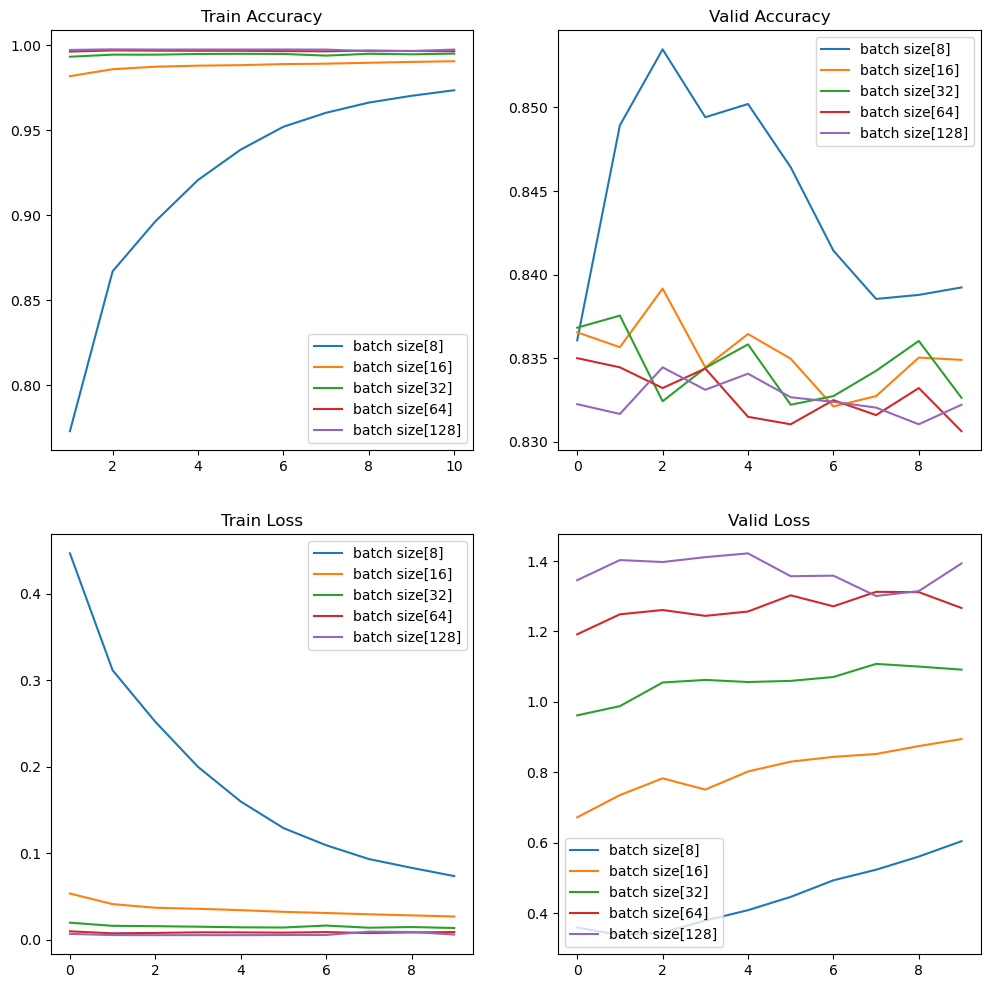

In [189]:
fig = plt.figure(figsize=(12,12))
ax_train_accuracy = fig.add_subplot(2, 2, 1)
ax_train_loss = fig.add_subplot(2, 2, 3)
ax_valid_accuracy = fig.add_subplot(2, 2, 2)
ax_valid_loss = fig.add_subplot(2, 2, 4)

for train_dataloader in train_loaderset:
    bs = train_dataloader.batch_size
    print("batch_size: ", bs)
    num_epochs = 10

    # Training loop
    best_val_loss = float('inf')
    tqdm.clear

    valid_loss_list = []
    train_loss_list = []
    valid_accuracy_list = []
    train_accuracy_list = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        train_correct = 0
        train_total = 0
        model.train()

        progress = tqdm(train_dataloader)

        for i, (batch_X, batch_y) in enumerate(progress, start=1):
            # Forward pass
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # batch_X.shape == (batch_size, max_len)
            logits = model(batch_X)

            # Compute loss
            loss = criterion(logits, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy and loss
            train_loss += loss.item()
            train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            train_total += batch_y.size(0)

        train_accuracy = train_correct / train_total
        train_loss /= len(train_dataloader)

        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        
        # Validation
        val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

        valid_loss_list.append(val_loss)
        valid_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # 검증 손실이 최소일 때 체크포인트 저장
        if val_loss < best_val_loss:
            print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
            best_val_loss = val_loss
            torch.save(model.state_dict(),f'best_model_checkpoint_{bs}_hdn_{hidden_dim}.pth')
    
    ax_train_accuracy.plot(np.arange(1, num_epochs+1), train_accuracy_list, label=f'batch size[{bs}]')
    ax_valid_accuracy.plot(valid_accuracy_list, label=f'batch size[{bs}]')
    ax_train_loss.plot(train_loss_list, label=f'batch size[{bs}]')    
    ax_valid_loss.plot(valid_loss_list, label=f'batch size[{bs}]')
    
ax_valid_accuracy.set_title('Valid Accuracy')
ax_valid_loss.set_title('Valid Loss')
ax_train_loss.set_title('Train Loss')
ax_train_accuracy.set_title('Train Accuracy')

ax_train_accuracy.legend()
ax_valid_accuracy.legend()
ax_train_loss.legend()
ax_valid_loss.legend()

fig.savefig(f'fig_batchsize_{learning_rate}_{num_epochs}.png')

In [167]:
np.arange(0, num_epochs)

array([0])

In [70]:
ax.title.set_text

<bound method Text.set_text of Text(0.5, 1.0, '')>

In [69]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = mecab.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag


In [45]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')


100%|████████████████████████████████████| 29079/29079 [02:16<00:00, 213.08it/s]


Best model validation loss: 0.4178
Best model validation accuracy: 0.8461


100%|████████████████████████████████████| 48852/48852 [03:44<00:00, 218.06it/s]

Best model test loss: 0.4297
Best model test accuracy: 0.8464


In [47]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"
print(predict(test_input, model, word_to_index, index_to_tag))
test_input = "이딴게 영화냐 ㅉㅉ"
print(predict(test_input, model, word_to_index, index_to_tag))
test_input = "감독 뭐하는 놈이냐?"

print(predict(test_input, model, word_to_index, index_to_tag))
test_input = "와 개쩐다 정말 세계관 최강자들의 영화다"
print(predict(test_input, model, word_to_index, index_to_tag))

긍정
부정
부정
긍정
